# Passive and active colloidal chemotaxis in a microfluidic channel: mesoscopic and stochastic models

**Author:** Pierre de Buyl and Laurens Deprez  
*Supplemental information to the article by L. Deprez and P. de Buyl*

The data originates from the RMPCDMD simulation program. Please read its documentation and the
published paper for meaningful use of this notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erfc, erf
from scipy.integrate import quad, nquad
from collections import namedtuple
import h5py
import os.path
from glob import glob
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.subplot.hspace'] = 0.25
plt.rcParams['figure.subplot.wspace'] = 0.
plt.rcParams['figure.subplot.left'] = 0.05
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['figure.subplot.bottom'] = 0.19
plt.rcParams['figure.subplot.top'] = 0.91
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
colors = ['#1f77b4', '#ff7f0e']

In [2]:
%load_ext Cython

In [29]:
# Set the following variable to point to the location of the chemotaxis mesoscopic simulations
mesoscopic_directory = '.'

In [4]:
# compute D, v_flow

fluid = namedtuple('fluid', ['tau', 'T', 'rho', 'alpha', 'm', 'a', 'eta'])
cell = namedtuple('cell', ['Ly', 'Lz', 'g'])
colloid = namedtuple('colloid', ['sigma', 'R'])

fluid.tau = 0.5
fluid.T = 0.33
fluid.rho = 10
fluid.alpha = 2.6
fluid.m = 1
fluid.a = 1

buffer_length = 20

# Kapral review Eq. 55
eta_kin = fluid.T * fluid.tau * fluid.rho / (2*fluid.m) * \
    (5*fluid.rho-(fluid.rho - 1 + np.exp(-fluid.rho))*(2 - np.cos(fluid.alpha)-np.cos(2*fluid.alpha)))/ \
    ((fluid.rho - 1 + np.exp(-fluid.rho))*(2 - np.cos(fluid.alpha)-np.cos(2*fluid.alpha)))
# Kapral review Eq. 56
eta_coll = fluid.m / (18 * fluid.a * fluid.tau) * (fluid.rho - 1 + np.exp(-fluid.rho))*(1-np.cos(fluid.alpha))
fluid.eta = eta_kin + eta_coll
print("Viscosity", fluid.eta)
fluid.D = fluid.T*fluid.tau/(2*fluid.m) * (3*fluid.rho/((fluid.rho - 1 + np.exp(-fluid.rho))*(1-np.cos(fluid.alpha))) - 1)
print("Self-diffusion D", fluid.D)

cell.Ly = 60
cell.Lz = 15
cell.g = 1/1000

def v_of_eta(fluid, cell):
    return fluid.rho*cell.g*cell.Lz**2/(8*fluid.eta)

v_max = v_of_eta(fluid, cell)
v_av = 2/3*v_max
print("Flow maximum ", v_max)
print("Flow average ", v_av)
print("Poiseuille flow Peclet number", v_av*cell.Lz/fluid.D)

colloid.sigma = 3
colloid.R = colloid.sigma*2**(1/6)
all_EPS = ['0.25', '0.50', '1.00', '2.00', '4.00']

Viscosity 2.95090824757
Self-diffusion D 0.0655964394275
Flow maximum  0.0953096390684
Flow average  0.063539759379
Poiseuille flow Peclet number 14.5296970232


In [5]:
# Quantities for the catalytic reaction on the surface of the colloid

probability = 1
k0 = probability*colloid.R**2*np.sqrt(8*np.pi*fluid.T/fluid.m)
kD = 4*np.pi*colloid.R*fluid.D


In [6]:
# define c_A(x,y) and lambda (derivative)

def c_A(x,y):
    return fluid.rho * 0.5*(1+erf(-(y-cell.Ly/2)/np.sqrt(4*fluid.D*x/v_max)))

def lam(x,y):
    return -fluid.rho*np.exp(-(y-cell.Ly/2)**2/(4*fluid.D*x/v_max))/np.sqrt(4*np.pi*fluid.D*x/v_max)

In [7]:
# define Lambda(R, eps)

def V(r, sigma, eps):
    return 4*eps*((sigma/r)**12-(sigma/r)**6) + eps

def integrand(r, sigma, eps):
    return r*np.exp(-V(r, sigma, eps)/fluid.T)

def Lambda(R, eps):
    result, error = quad(integrand, colloid.R/2, colloid.R, args=(colloid.sigma, eps))
    return result - colloid.R**2/2


In [8]:
# define placeholder dicts for the numerical data

passive_sphere_meso = {}
passive_sphere_stoc = {}
active_sphere_meso = {}
active_sphere_stoc = {}
nanomotor_meso = {}
nanomotor_stoc = {}


## Single passive colloid

Here, the setup 

In [9]:
# Single passive colloid
# Lambda lambda

sigma = colloid.sigma
R = colloid.R
y_shift = 3.4

dt = 0.01
gamma = 4*np.pi*fluid.eta*sigma
D = fluid.T/gamma
x_factor = np.sqrt(2*D*dt)
y_factor = np.sqrt(2*D*dt)

def run_single_passive(passive_EPS):
    F_factor = 8*np.pi*fluid.T/3 * R * (Lambda(R, 1)-Lambda(R, float(passive_EPS)))/gamma
    x, y = sigma, cell.Ly/2 + y_shift
    xy_data = []
    for t in range(1000):
        for tt in range(50):
            F_y = F_factor * lam(x, y)
            xi_x, xi_y = np.random.normal(size=(2,))
            x += v_max*dt + x_factor*xi_x
            y += F_y*dt + y_factor*xi_y
        xy_data.append((x,y))
    return np.array(xy_data)


In [30]:
# Collect mesoscopic simulation data

for passive_EPS in ['0.25', '0.50', '1.00', '2.00', '4.00']:
    runs = glob(os.path.join(mesoscopic_directory, 'passive_sphere_EPS{}_*/passive_sphere_no_solvent.h5'.format(passive_EPS)))

    runs.sort()
    xy_data = []
    for r in runs:
        with h5py.File(r, 'r') as a:
            xy_data.append(a['/particles/dimer/position/value'][:,0,:2])

    passive_sphere_meso[passive_EPS] = np.array(xy_data)

In [11]:
# Generate stochastic simulation data

for passive_EPS in all_EPS:
    passive_sphere_stoc[passive_EPS] = np.array([run_single_passive(passive_EPS) for i in range(16)])


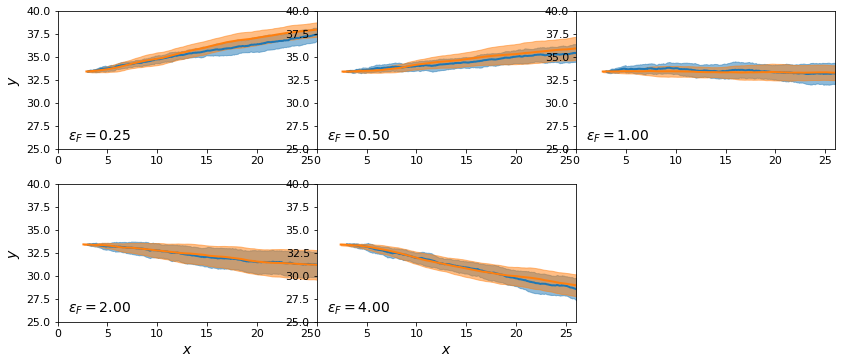

In [31]:
plt.figure(figsize=(12,6))
for i, passive_EPS in enumerate(all_EPS):
    plt.subplot(2, 3, i+1)

    m = passive_sphere_stoc[passive_EPS].mean(axis=0).T
    s = passive_sphere_stoc[passive_EPS].std(axis=0).T
    color = colors[0]
    plt.fill_between(m[0,:], m[1,:]-s[1,:], m[1,:]+s[1,:], color=color, alpha=0.5)
    plt.plot(*m, color=color, lw=2)

    m = passive_sphere_meso[passive_EPS][:,450:].mean(axis=0).T
    s = passive_sphere_meso[passive_EPS][:,450:].std(axis=0).T
    m[0,:] -= 20

    color = colors[1]
    plt.fill_between(m[0,:], m[1,:]-s[1,:], m[1,:]+s[1,:], color=color, alpha=0.5)
    plt.plot(*m, color=color, lw=2)

    plt.xlim(0, 26)
    plt.ylim(25, 40)
    plt.text(1, 26, r'$\epsilon_F='+passive_EPS+'$')
    if i//3==1: plt.xlabel(r'$x$')
    if i%3==0: plt.ylabel(r'$y$')

## Single active colloid

In [13]:
# Single active colloid
# Lambda c_2


sigma = colloid.sigma
R = colloid.R
y_shift = 3.4

dt = 0.01
gamma = 4*np.pi*fluid.eta*sigma
D = fluid.T/gamma
x_factor = np.sqrt(2*D*dt)
y_factor = np.sqrt(2*D*dt)

def run_single_active(active_EPS):
    F_factor = -8*np.pi*fluid.T/3 * R * k0/(k0+2*kD) * (Lambda(R, 1)-Lambda(R, float(active_EPS)))/gamma
    x, y = sigma, cell.Ly/2 + y_shift
    xy_data = []
    for t in range(1000):
        for tt in range(50):
            F_y = F_factor * lam(x, y)
            xi_x, xi_y = np.random.normal(size=(2,))
            x += v_max*dt + x_factor*xi_x
            y += F_y*dt + y_factor*xi_y
        xy_data.append((x,y))
    return np.array(xy_data)



In [32]:
# Collect simulation data

for active_EPS in all_EPS:
    runs = glob(os.path.join(mesoscopic_directory,'active_sphere_EPS{}_*/active_sphere_no_solvent.h5'.format(active_EPS)))
    runs.sort()
    active_simulation = []
    for r in runs:
        with h5py.File(r, 'r') as a:
            active_simulation.append(a['/particles/dimer/position/value'][:,0,:2])
    active_sphere_meso[active_EPS] = np.array(active_simulation)

In [27]:
# Generate stochastic simulation data

for active_EPS in all_EPS:
    active_sphere_stoc[active_EPS] = np.array([run_single_active(active_EPS) for i in range(16)])

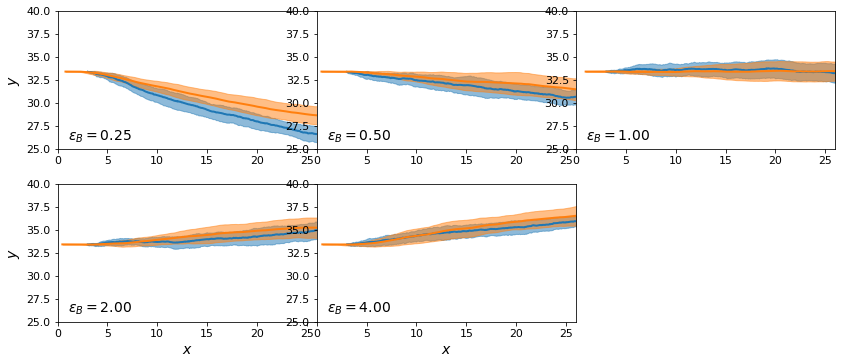

In [33]:
plt.figure(figsize=(12,6))
for i, active_EPS in enumerate(all_EPS):
    plt.subplot(2, 3, i+1)
    
    m = active_sphere_stoc[active_EPS].mean(axis=0).T
    s = active_sphere_stoc[active_EPS].std(axis=0).T

    color = colors[0]
    plt.fill_between(m[0,:], m[1,:]-s[1,:], m[1,:]+s[1,:], color=color, alpha=0.5)
    plt.plot(*m, color=color, lw=2)

    m = active_sphere_meso[active_EPS][:,400:].mean(axis=0).T
    s = active_sphere_meso[active_EPS][:,400:].std(axis=0).T
    m[0,:] -= 20

    color = colors[1]
    plt.fill_between(m[0,:], m[1,:]-s[1,:], m[1,:]+s[1,:], color=color, alpha=0.5)
    plt.plot(*m, color=color, lw=2)

    plt.xlim(0, 26)
    plt.ylim(25, 40)
    plt.text(1, 26, r'$\epsilon_B='+active_EPS+'$')
    if i//3==1: plt.xlabel(r'$x$')
    if i%3==0: plt.ylabel(r'$y$')


## Dimer nanomotor

In [17]:
d = 6.7

def F_C_y(x, y, phi):
    return 8*np.pi*fluid.T/3 * colloid.R * k0/(k0+2*kD) * lam(x-d*np.cos(phi)/2, y-d*np.sin(phi)/2)

def torque(f_c_y, f_n_x, f_n_y, phi):
    return (np.cos(phi) * (f_c_y - f_n_y) + np.sin(phi) * f_n_x)*d/2

def rotate_xy(x, y, phi):
    rot = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    return np.dot(rot, (x,y))


In [18]:
print('cdef double RHO =', fluid.rho)
print('cdef double FLUID_D =', fluid.D)
print('cdef double V_MAX =', v_max)
print('cdef double R =', colloid.R)
print('cdef double T =', fluid.T)
print('cdef double k0 =', k0)
print('cdef double kD =', kD)

cdef double RHO = 10
cdef double FLUID_D = 0.0655964394275
cdef double V_MAX = 0.0953096390684
cdef double R = 3.367386144928119
cdef double T = 0.33
cdef double k0 = 32.6559814827
cdef double kD = 2.77576727425


In [19]:
%%cython

import cython
cimport cython
import numpy as np
cimport numpy as np
from libc.math cimport exp, abs, cos, sin, sqrt, acos, erf
from scipy.integrate import nquad

cdef double d = 6.7

cdef double RHO = 10
cdef double LY = 60
cdef double FLUID_D = 0.06559643942750612
cdef double V_MAX = 0.095309639068441587
cdef double R = 3.367386144928119
cdef double T = 0.33
cdef double k0 = 32.6559814827
cdef double kD = 2.77576727425
cdef double PI = np.pi

@cython.cdivision(True)
cdef double c_A(double x,double y):
    return RHO * 0.5*(1+erf(-(y-LY/2)/sqrt(4*FLUID_D*x/V_MAX)))

@cython.cdivision(True)
cdef double lam(double x, double y):
    return -RHO*exp(-(y-LY/2)**2/(4*FLUID_D*x/V_MAX))/sqrt(4*PI*FLUID_D*x/V_MAX)

@cython.cdivision(True)
cdef double polar_c_B(double theta, double varphi, double r, double x, double y, double phi):
    """Concentration of B at location theta, varphi, r from the N bead.
    x, y are the c.o.m. coordinates and phi is the orientation of the dimer."""
    cdef double x_C, y_C, x_N, y_N, c0, c1, c2, x_p, y_p, z_p, r_0
    x_C = x + d*cos(phi)/2
    y_C = y + d*sin(phi)/2
    x_N = x - d*cos(phi)/2
    y_N = y - d*sin(phi)/2
    
    c0 = c_A(x_C, y_C)
    c1 = -k0/(k0+kD)*c0
    c2 = -k0/(k0+2*kD)*lam(x_C, y_C)

    x_p = x_N + r*cos(varphi)*sin(theta)
    y_p = y_N + r*cos(theta)
    z_p = r*sin(varphi)*sin(theta)

    r_0 = sqrt((x_p-x_C)**2+(y_p-y_C)**2+z_p**2)
    theta_0 = acos((r*cos(theta)-d*sin(phi))/r_0)

    return -c1*(R/r_0) - c2*(R/r_0)**2*cos(theta_0)

@cython.cdivision(True)
cdef double F_C_y(double x, double y, double phi):
    return 8*PI*T/3 * R * k0/(k0+2*kD) * lam(x-d*cos(phi)/2, y-d*sin(phi)/2)

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.wraparound(False)
def F_N(double x, double y, double phi):
    cdef double fx = 0
    cdef double fy = 0
    cdef int i_theta, i_varphi, N_theta, N_varphi
    cdef double c, th, vphi
    N_theta = 32
    N_varphi = 32
    cdef double inv_N_theta = 1.0/N_theta
    cdef double inv_N_varphi = 1.0/N_varphi
    for i_theta in range(N_theta):
        th = (i_theta+0.5)*PI*inv_N_theta
        for i_varphi in range(N_varphi):
            vphi = (i_varphi+0.5)*2*PI*inv_N_varphi
            c = polar_c_B(th, vphi, R, x, y, phi)
            fx = fx + c*sin(th)*sin(th)*cos(vphi)
            fy = fy + c*sin(th)*cos(th)
    factor = 2*T*PI*inv_N_theta*2*PI*inv_N_varphi
    return fx*factor, fy*factor

cdef double torque(double f_c_y, double f_n_x, double f_n_y, double phi):
    return (cos(phi) * (f_c_y - f_n_y) + sin(phi) * f_n_x)*d/2



In [20]:
def run_nm(nanomotor_EPS):

    Lambda_NM = Lambda(colloid.R, float(nanomotor_EPS)) - Lambda(colloid.R, 1)
    y_shift = 3.4
    x, y = 5, cell.Ly/2 + y_shift
    phi = 0

    D_para = 0.002
    gamma_para = fluid.T/D_para
    D_perp = 0.0015
    gamma_perp = fluid.T/D_perp
    D_r = 1.4e-4
    gamma_r = fluid.T/D_r

    dt = 0.025
    x_para_factor = np.sqrt(2*D_para*dt)
    x_perp_factor = np.sqrt(2*D_perp*dt)

    phi_factor = np.sqrt(2*D_r*dt)
    dimer_data = []
    for t in range(500):
        for i in range(20):
            F_y = Lambda_NM*F_C_y(x, y, phi)
            F_N_x, F_N_y = F_N(x, y, phi)
            F_N_x, F_N_y = Lambda_NM*F_N_x, Lambda_NM*F_N_y
            F_com_x = F_N_x
            F_com_y = F_N_y + F_y

            xi_para, xi_perp, xi_phi = np.random.normal(size=(3,))
            F_para, F_perp = rotate_xy(F_com_x, F_com_y, -phi)
            F_para = F_para*dt/gamma_para + x_para_factor*xi_para
            F_perp = F_perp*dt/gamma_perp + x_perp_factor*xi_perp
            F_com = rotate_xy(F_para, F_perp, phi)
            x += v_max*dt + F_com[0]
            y += F_com[1]
            phi += torque(F_y, F_N_x, F_N_y, phi)*dt / gamma_r + phi_factor*xi_phi
        dimer_data.append((x,y,phi))
    return np.array(dimer_data)


In [21]:
for nanomotor_EPS in all_EPS:
    nanomotor_stoc[nanomotor_EPS] = np.array([run_nm(nanomotor_EPS) for i in range(12)])

In [35]:
# Collect simulation data

for nanomotor_EPS in all_EPS:
    runs = glob(os.path.join(mesoscopic_directory,'nanomotor_EPS{}_*/nanomotor_no_solvent.h5'.format(nanomotor_EPS)))
    runs.sort()
    nanomotor_simulation = []
    for r in runs:
        with h5py.File(r, 'r') as a:
            r = a['/particles/dimer/position/value'][:,:,:]
            orientation = r[:,0,:] - r[:,1,:]
            r = r.mean(axis=1)
            r[:,2] = np.arctan2(orientation[:,1], orientation[:,0])
            nanomotor_simulation.append(r.copy())
    nanomotor_meso[nanomotor_EPS] = np.array(nanomotor_simulation)

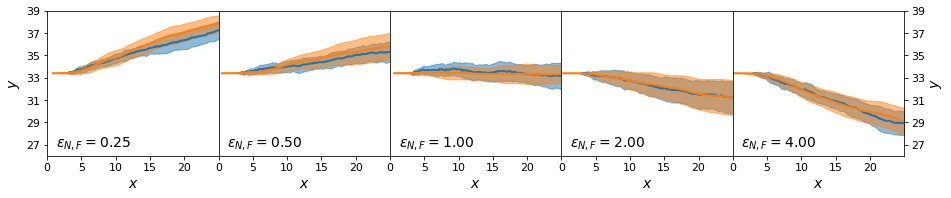

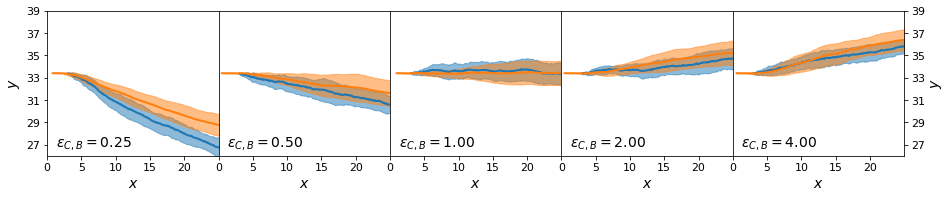

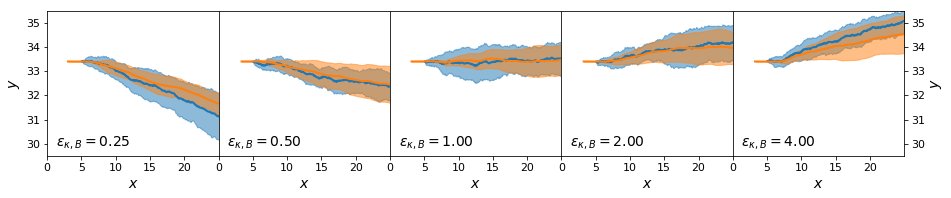

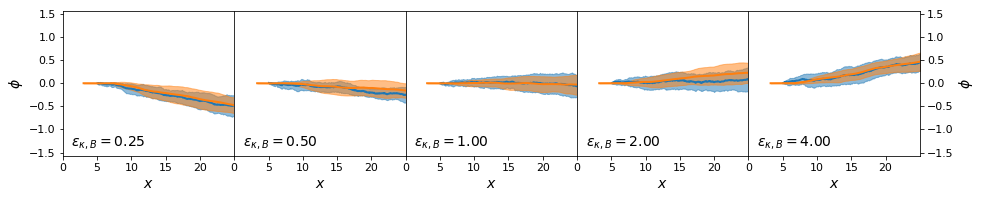

In [37]:

nanomotor_plot = {
    'name': 'nanomotor',
    'stoc': nanomotor_stoc,
    'meso': nanomotor_meso,
    'xlim': (0, 25),
    'ylim': (29.5, 35.5),
    'xticks': np.linspace(0, 20, 5),
    'yticks': np.linspace(30, 35, 6),
    'label': r'{\kappa,B}',
    'ylabel': r'$y$',
    'idx': 1,
}

nanomotor_phi_plot = {
    'name': 'nanomotor_phi',
    'stoc': nanomotor_stoc,
    'meso': nanomotor_meso,
    'xlim': (0, 25),
    'ylim': (-np.pi/2, np.pi/2),
    'xticks': np.linspace(0, 20, 5),
    'yticks': np.linspace(-1.5, 1.5, 7),
    'label': r'{\kappa,B}',
    'ylabel': r'$\phi$',
    'idx': 2,
}

active_sphere_plot = {
    'name': 'active_sphere',
    'stoc': active_sphere_stoc,
    'meso': active_sphere_meso,
    'xlim': (0, 25),
    'ylim': (26, 39),
    'xticks': np.linspace(0, 20, 5),
    'yticks': np.linspace(27, 39, 7),
    'label': '{C,B}',
    'ylabel': r'$y$',
    'idx': 1,
}

passive_sphere_plot = {
    'name': 'passive_sphere',
    'stoc': passive_sphere_stoc,
    'meso': passive_sphere_meso,
    'xlim': (0, 25),
    'ylim': (26, 39),
    'xticks': np.linspace(0, 20, 5),
    'yticks': np.linspace(27, 39, 7),
    'label': '{N,F}',
    'ylabel': r'$y$',
    'idx': 1,
}


for data_plot in [passive_sphere_plot, active_sphere_plot, nanomotor_plot, nanomotor_phi_plot]:
    fig = plt.figure(figsize=(529*0.9/36,2.8))
    idx = data_plot['idx']
    for i, EPS in enumerate(all_EPS):
        ax1 = plt.subplot(1, 5, i+1)

        m = data_plot['stoc'][EPS][:,:,:].mean(axis=0)
        s = data_plot['stoc'][EPS][:,:,:].std(axis=0)

        color = colors[0]
        ax1.fill_between(m[:,0], m[:,idx]-s[:,idx], m[:,idx]+s[:,idx], color=color, alpha=0.5)
        ax1.plot(m[:,0], m[:,idx], color=color, lw=2)

        m = data_plot['meso'][EPS][:,400:].mean(axis=0)
        s = data_plot['meso'][EPS][:,400:].std(axis=0)
        m[:,0] -= buffer_length

        color = colors[1]
        ax1.fill_between(m[:,0], m[:,idx]-s[:,idx], m[:,idx]+s[:,idx], color=color, alpha=0.5)
        ax1.plot(m[:,0], m[:,idx], color=color, lw=2)

        ax1.set_xlim(*data_plot['xlim'])
        ax1.set_xticks(data_plot['xticks'])
        ax1.set_ylim(*data_plot['ylim'])
        if i==0:
            ax1.set_yticks(data_plot['yticks'])
            ax1.set_ylabel(data_plot['ylabel'])
        elif i==4:
            ax1.yaxis.tick_right()
            ax1.yaxis.set_label_position("right")
            ax1.set_yticks(data_plot['yticks'])
            ax1.set_ylabel(data_plot['ylabel'])
        else:
            ax1.set_yticks([])
        ax1.set_xlabel(r'$x$')        

        plt.text(0.05, 0.07, r'$\epsilon_'+data_plot['label']+'='+EPS+'$', transform=ax1.transAxes)

    plt.savefig(data_plot['name']+'_panel.pdf')


### Extra slides

[0.10000000000000001, 20.0, 0, 60]

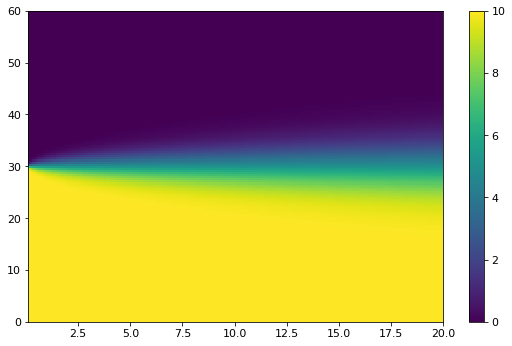

In [24]:
X, Y = np.meshgrid(np.linspace(0.1, 20, 180),np.linspace(0, cell.Ly, 150))

plt.pcolormesh(X, Y, c_A(X, Y), cmap=plt.cm.viridis)
plt.colorbar()
plt.axis([X.min(), X.max(), 0, cell.Ly])


[0.10000000000000001, 20.0, 0, 60]

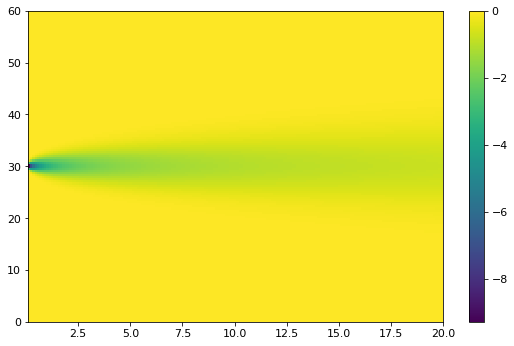

In [25]:
plt.pcolormesh(X, Y, lam(X, Y), cmap=plt.cm.viridis)
plt.colorbar()
plt.axis([X.min(), X.max(), 0, cell.Ly])


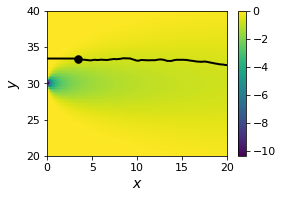

In [26]:
from matplotlib.figure import SubplotParams
params = SubplotParams(left=0.2)
plt.figure(figsize=(150/36,2.8), subplotpars=params)

EPS='1.00'

X, Y = np.meshgrid(np.linspace(0.1, 20, 180),np.linspace(0, cell.Ly, 300))

plt.pcolormesh(X, Y, lam(X, Y), cmap=plt.cm.viridis, rasterized=True)
plt.colorbar()

xy = passive_sphere_meso[EPS][0,:,:].copy()
idx = np.searchsorted(xy[:,0], buffer_length)
xy = xy[idx:,:] - np.array([buffer_length,0])
color = colors[1]
plt.plot(xy[:,0], xy[:,1], color='k', lw=2)

x_track = [colloid.R]
y_track = [cell.Ly/2 + y_shift]
plt.plot(x_track, y_track, color='k', marker='o', ms=7.5)

plt.xlim(0, 20)
plt.ylim(cell.Ly/2-10, cell.Ly/2+10)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.savefig('trajectory_and_gradient_'+EPS+'.pdf')